## Forest Fires - Optimizing Model Prediction

Sourced from the UCI Machine Learing Repository: [Forest Fires](https://archive.ics.uci.edu/dataset/162/forest+fires)

## Import Libraries

In [711]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score, train_test_split

## Load Data

In [712]:
fires = pd.read_csv('data/fires.csv')

## Explore Data

A quick description of our columns:

| Variable Name | Type        | Description                                                                                          | Units            | Missing Values |
|--------------|------------|------------------------------------------------------------------------------------------------------|------------------|---------------|
| X            | Integer    | x-axis spatial coordinate within the Montesinho park map: 1 to 9                                   | -                | No            |
| Y            | Integer    | y-axis spatial coordinate within the Montesinho park map: 2 to 9                                   | -                | No            |
| month        | Categorical | Month of the year: 'jan' to 'dec'                                                                  | -                | No            |
| day          | Categorical | Day of the week: 'mon' to 'sun'                                                                    | -                | No            |
| FFMC         | Continuous | FFMC index from the FWI system: 18.7 to 96.20                                                       | -                | No            |
| DMC          | Integer    | DMC index from the FWI system: 1.1 to 291.3                                                         | -                | No            |
| DC           | Continuous | DC index from the FWI system: 7.9 to 860.6                                                          | -                | No            |
| ISI          | Continuous | ISI index from the FWI system: 0.0 to 56.10                                                         | -                | No            |
| temp         | Continuous | Temperature: 2.2 to 33.30                                                                          | Celsius degrees  | No            |
| RH           | Integer    | Relative humidity: 15.0 to 100                                                                      | %                | No            |
| wind         | Continuous | Wind speed: 0.40 to 9.40                                                                           | km/h             | No            |
| rain         | Integer    | Outside rain: 0.0 to 6.4                                                                           | mm/m²            | No            |
| area         | Integer    | The burned area of the forest: 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform). | ha               | No            |


In [713]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [714]:
# Drop unnecessary index column
fires.drop(columns=['Unnamed: 0'], inplace=True)

In [715]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    469 non-null    float64
 5   DMC     496 non-null    float64
 6   DC      474 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    496 non-null    float64
 9   RH      487 non-null    float64
 10  wind    482 non-null    float64
 11  rain    485 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


In [716]:
fires.isnull().sum()

X         0
Y         0
month     0
day       0
FFMC     48
DMC      21
DC       43
ISI       2
temp     21
RH       30
wind     35
rain     32
area      0
dtype: int64

## Establish Features, Target, and Reference

In [717]:
# Reference features
reference_features = ['temp', 'wind']

# Target variable
target = 'area'

# Instantiate reference model
reference_model = LinearRegression()

## Data Processing

### Examine Target Variable

<Axes: >

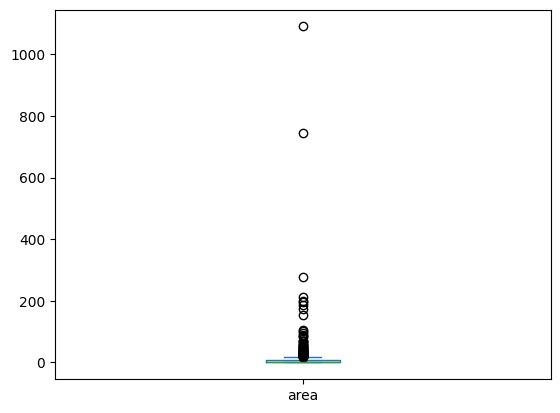

In [718]:
fires['area'].plot(kind='box')

<Axes: ylabel='Frequency'>

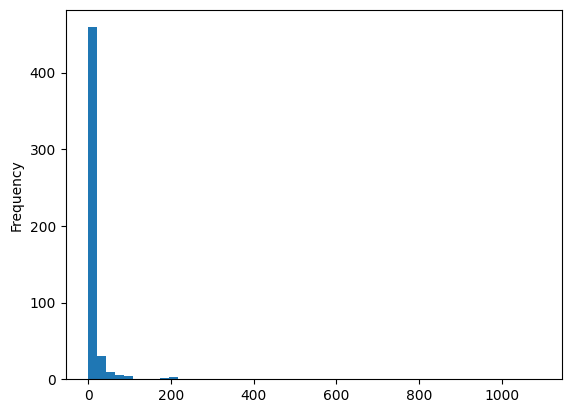

In [719]:
fires['area'].plot(kind='hist', bins=50)

### Log-Scale Target Variable

In [720]:
fires['area_scaled'] = np.log(fires['area'] + 1)

<Axes: ylabel='Frequency'>

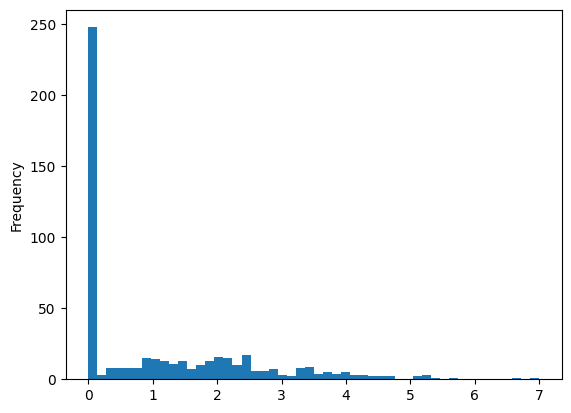

In [721]:
fires['area_scaled'].plot(kind='hist', bins=50)

### Examine `month` and `day`

In [722]:
fires['month'].value_counts(normalize=True, dropna=False)

month
aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: proportion, dtype: float64

In [723]:
fires['day'].value_counts(normalize=True, dropna=False)

day
sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: proportion, dtype: float64

### Create `Quarter` Column

In [724]:
def map_quarter(row):
    if row['month'] in ['jan', 'feb', 'mar']:
        return 1
    elif row['month'] in ['apr', 'may', 'jun']:
        return 2
    elif row['month'] in ['jul', 'aug', 'sep']:
        return 3
    elif row['month'] in ['oct', 'nov', 'dec']:
        return 4


fires['quarter'] = fires.apply(map_quarter, axis=1)

### Create Copy and Drop Unnecessary Columns

In [725]:
fires_copy = fires.copy()

fires_copy.drop(columns=['month', 'day', 'area', 'X', 'Y'], inplace=True)

### Visualize Correlations

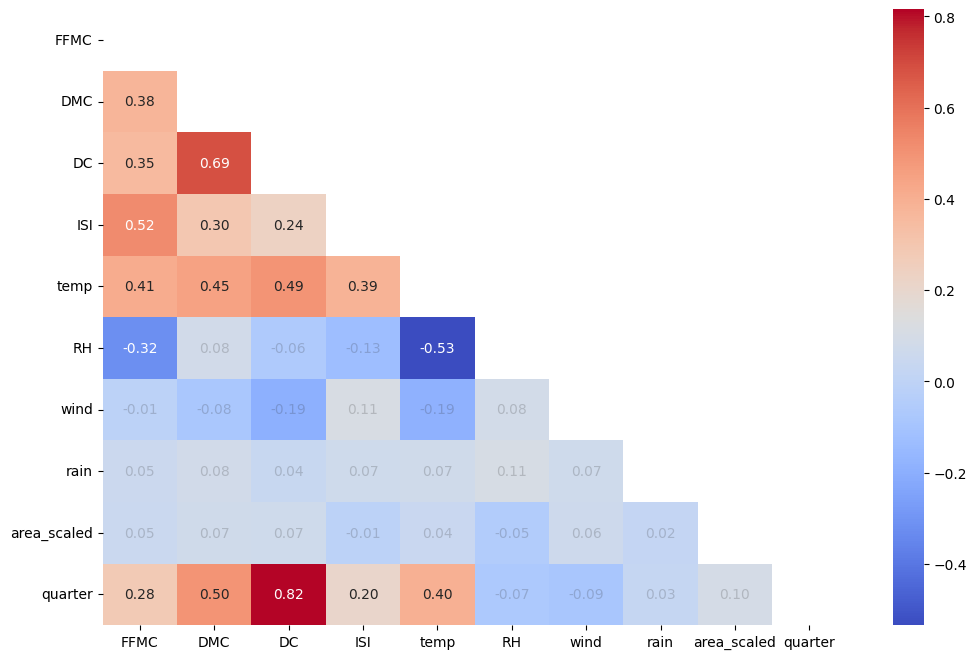

In [726]:
plt.figure(figsize=(12, 8))

ax = sns.heatmap(
    fires_copy.corr(), mask=np.triu(np.ones_like(fires_copy.corr(), dtype=bool)), annot=True, cmap='coolwarm', fmt='.2f'
)

for text in ax.texts:
    t = float(text.get_text())
    if -0.2 < t < 0.2:
        text.set_alpha(0.2)

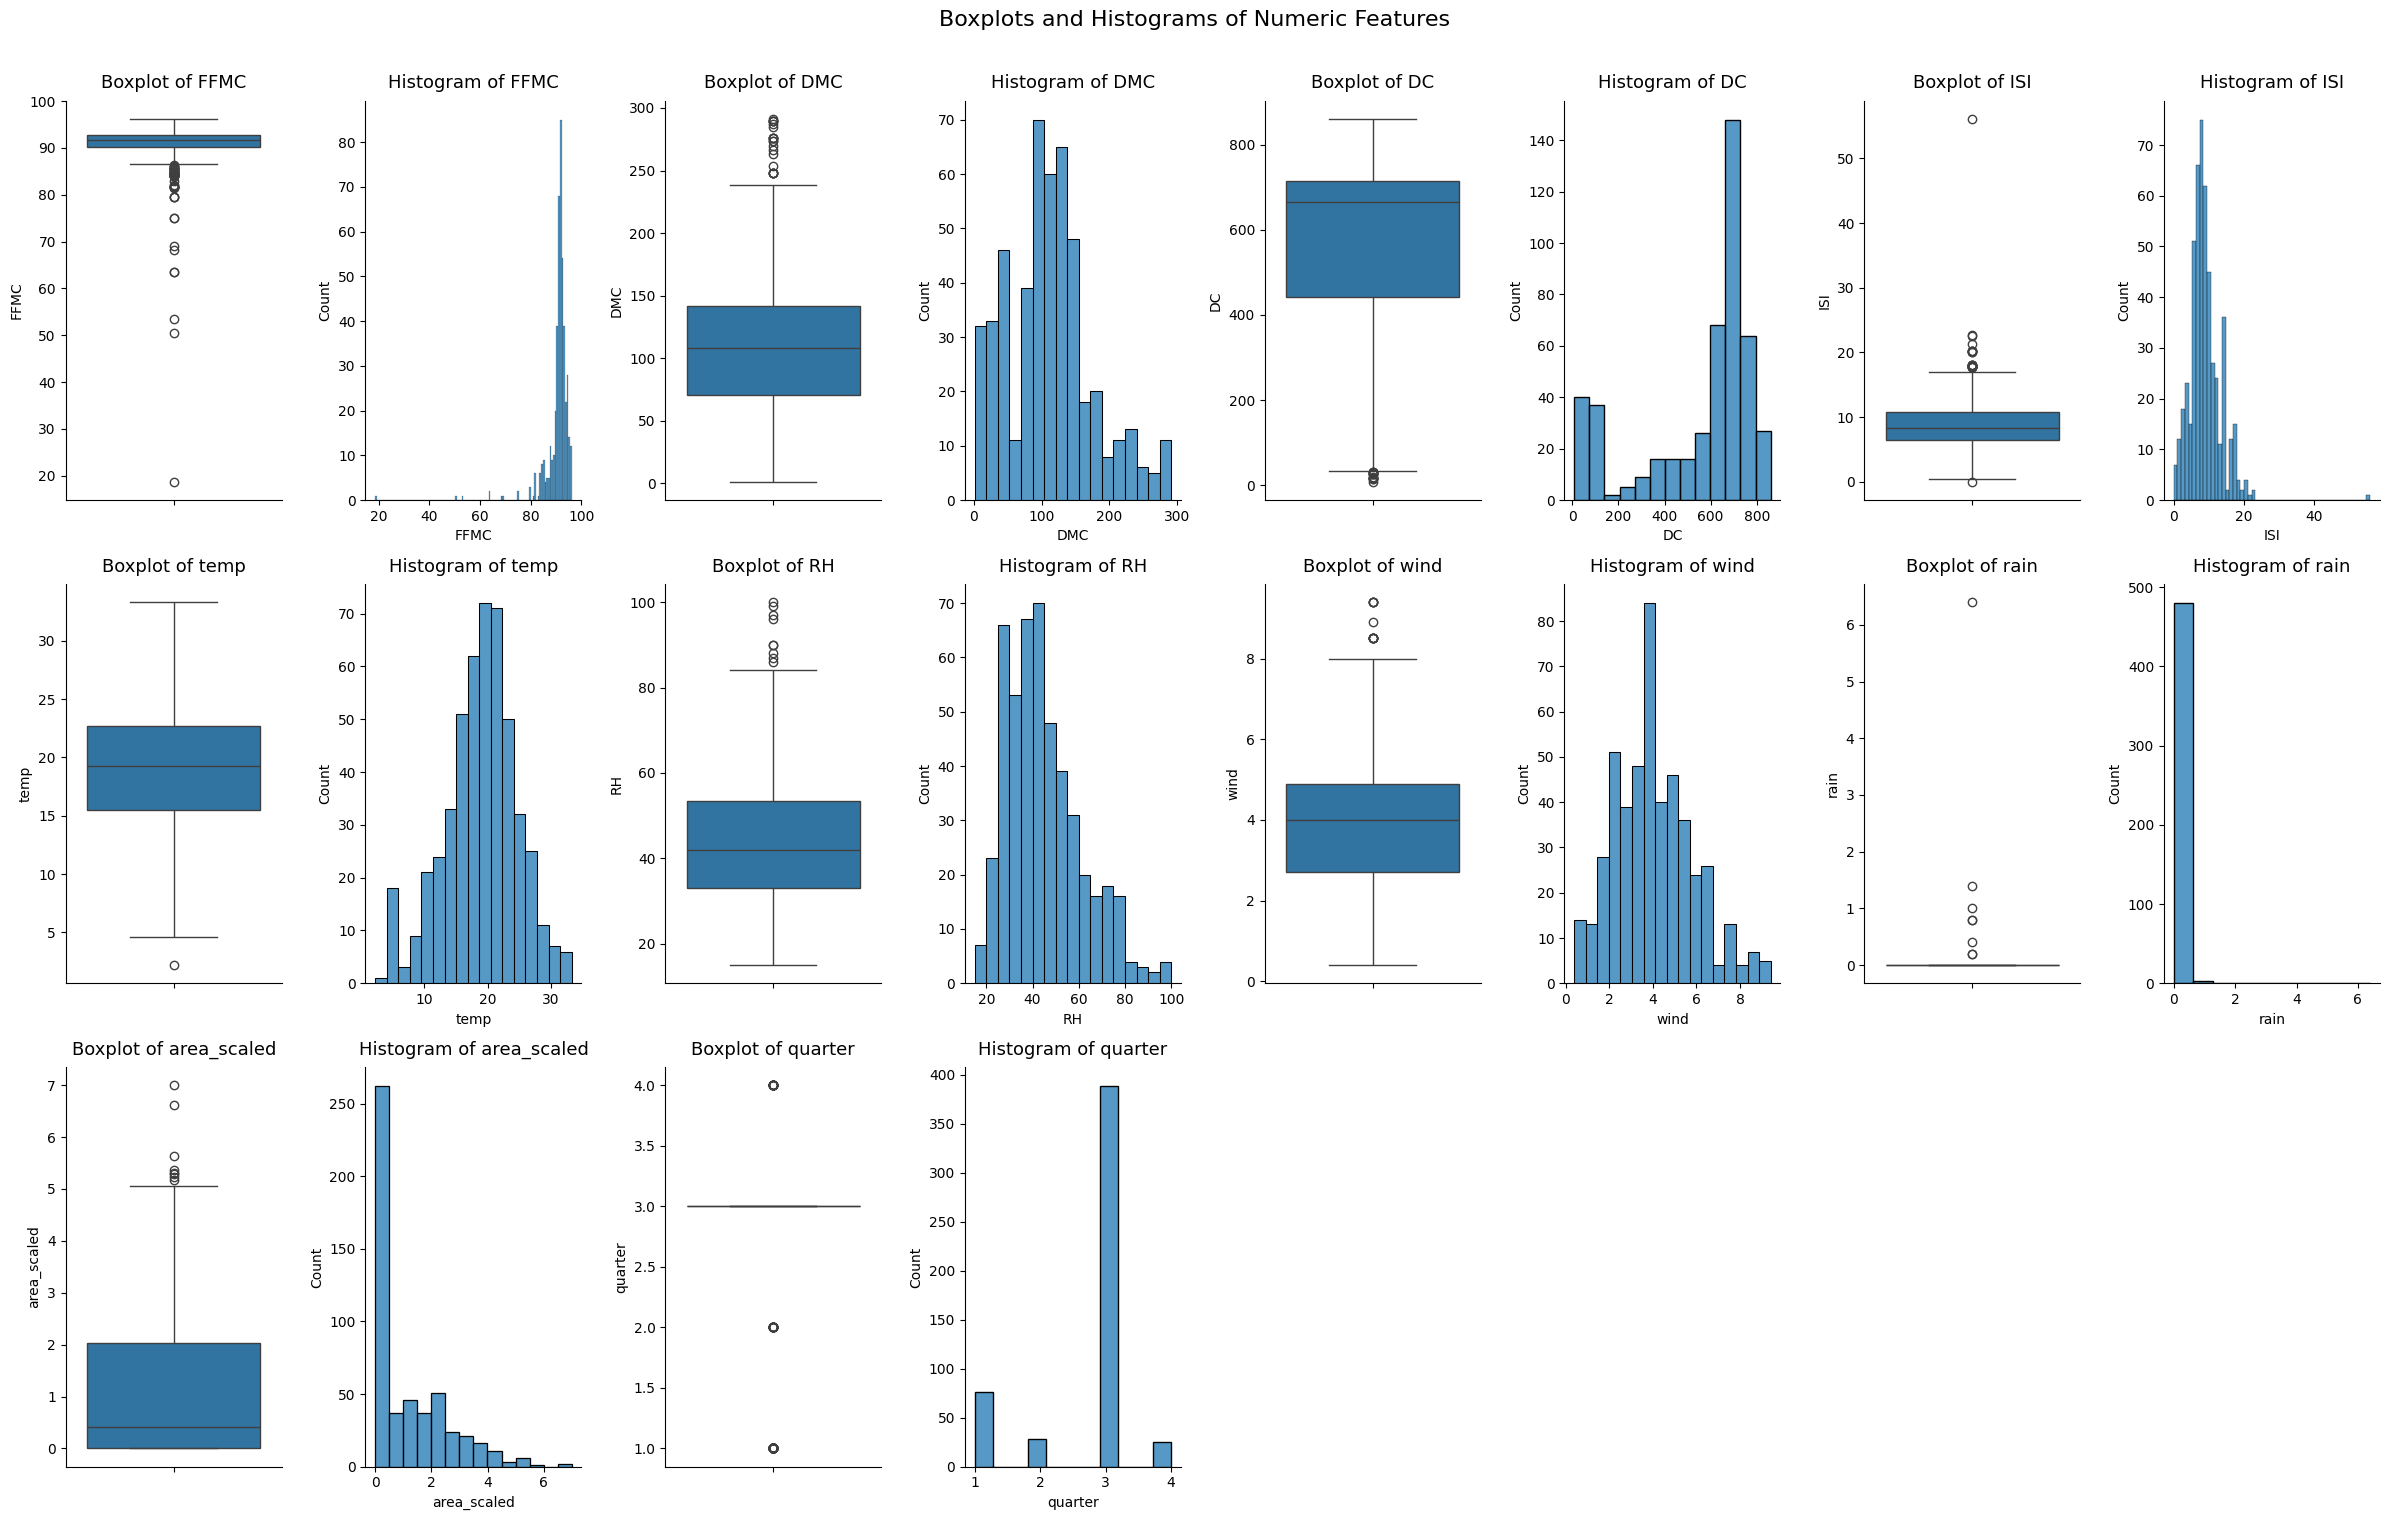

In [727]:
fig = plt.figure(figsize=(24, 15))

for i, feature in enumerate(fires_copy.select_dtypes(include=['number']).columns):
    ax1 = fig.add_subplot(3, 8, 2 * i + 1)
    sns.boxplot(fires_copy[feature], ax=ax1)
    ax1.set_title(f'Boxplot of {feature}', fontsize=13, y=1.01)

    ax2 = fig.add_subplot(3, 8, 2 * i + 2)
    sns.histplot(fires_copy[feature], ax=ax2)
    ax2.set_title(f'Histogram of {feature}', fontsize=13, y=1.01)

fig.suptitle('Boxplots and Histograms of Numeric Features', fontsize=16, y=1.01)

plt.tight_layout()
sns.despine()
plt.show()

### Impute Missing

In [728]:
fires_copy.isnull().sum()

FFMC           48
DMC            21
DC             43
ISI             2
temp           21
RH             30
wind           35
rain           32
area_scaled     0
quarter         0
dtype: int64

In [729]:
knn_imputer = KNNImputer(n_neighbors=5)

In [730]:
imputed = pd.DataFrame(
    knn_imputer.fit_transform(fires_copy.select_dtypes(include=['number'])),
    columns=fires_copy.select_dtypes(include=['number']).columns,
)

In [731]:
imputed.isnull().sum()

FFMC           0
DMC            0
DC             0
ISI            0
temp           0
RH             0
wind           0
rain           0
area_scaled    0
quarter        0
dtype: int64

In [732]:
imputed.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_scaled,quarter
0,86.2,26.20,94.30,5.1,15.54,51.0,6.70,0.0,0.0,1.0
1,90.6,79.28,669.10,6.7,18.00,33.0,0.90,0.0,0.0,4.0
2,90.6,43.70,438.18,6.7,14.60,33.0,1.30,0.0,0.0,4.0
3,91.7,33.30,77.50,9.0,8.30,97.0,4.00,0.2,0.0,1.0
4,89.3,51.30,102.20,9.6,11.40,99.0,4.48,0.0,0.0,1.0


### Scale Features

In [733]:
to_scale = imputed.drop(columns=['quarter', 'area_scaled'])

scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(to_scale), columns=to_scale.columns)

df = pd.concat([scaled, imputed[['quarter', 'area_scaled']]], axis=1)

## Visualize Relationships with Target

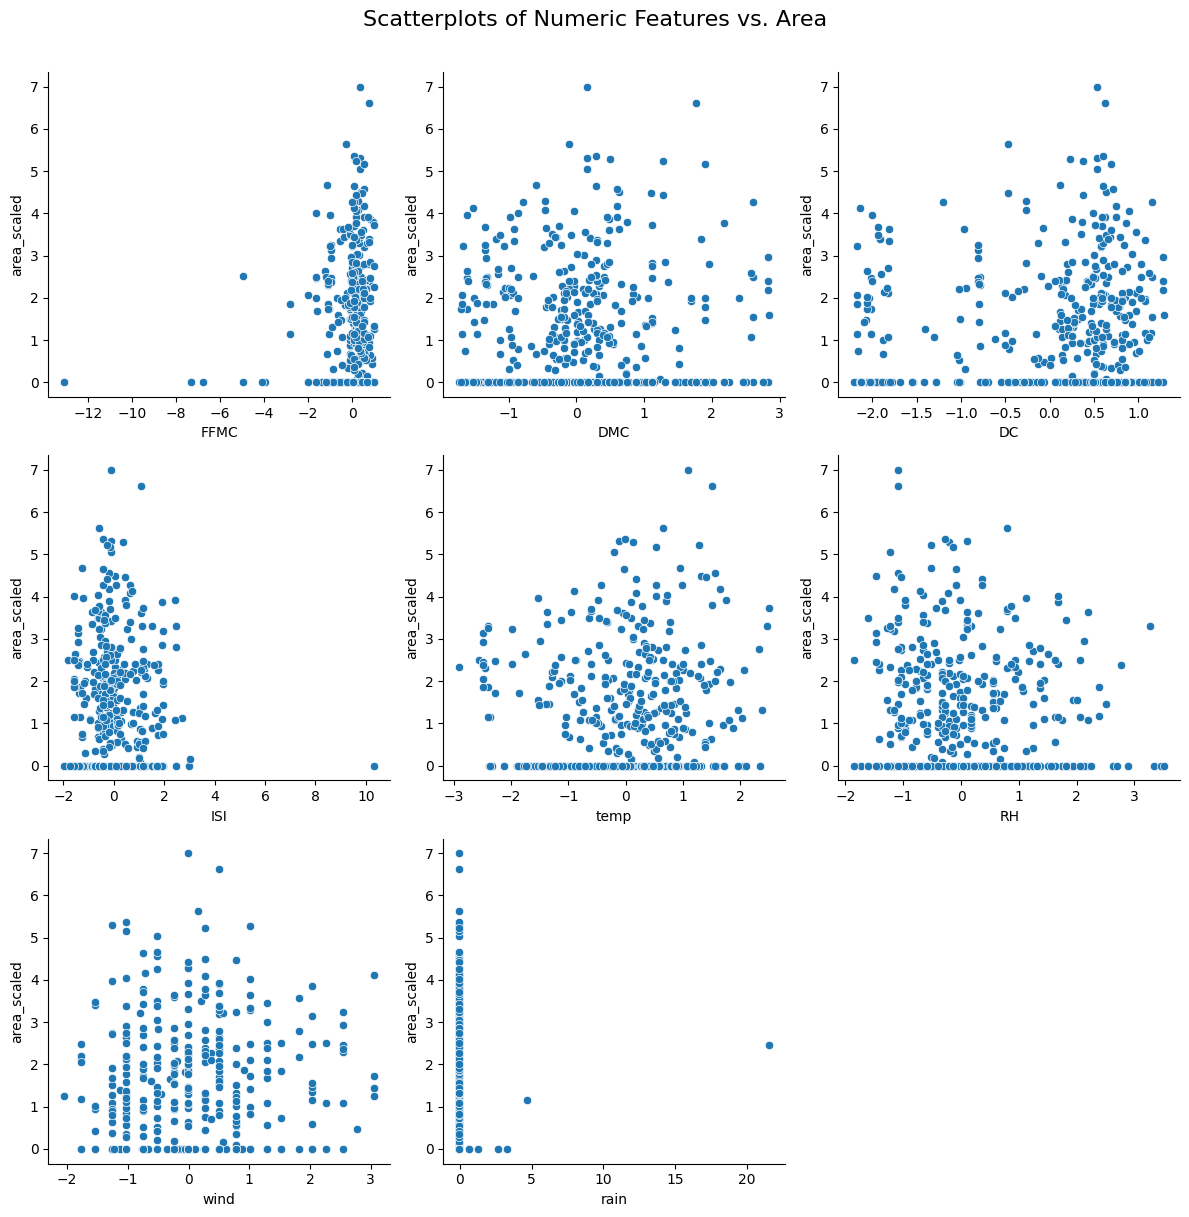

In [734]:
fig = plt.figure(figsize=(12, 12))

for i, col in enumerate(df.drop(columns=['quarter', 'area_scaled']).columns):
    ax = fig.add_subplot(3, 3, i + 1)
    sns.scatterplot(x=col, y='area_scaled', data=df, ax=ax)

fig.suptitle('Scatterplots of Numeric Features vs. Area', fontsize=16, y=1.01)

plt.tight_layout()
sns.despine()
plt.show()

## Subset Selection

### Establish Target Variable

In [735]:
y = df['area_scaled']

In [736]:
X = df.drop(columns=['area_scaled'])

### Utilize `SequentialFeatureSelector`

In [737]:
n_features_to_test = list(range(2, 9, 3))

print(f'Forward selection with {n_features_to_test} features')

forward_features = []

for n in n_features_to_test:
    seq_model = LinearRegression()

    selector = SequentialFeatureSelector(seq_model, n_features_to_select=n, direction='forward', cv=5)

    selector.fit(X, y)

    forward_features.append(selector.get_feature_names_out())

    print(n, 'features', selector.get_feature_names_out())

Forward selection with [2, 5, 8] features
2 features ['wind' 'quarter']
5 features ['FFMC' 'ISI' 'RH' 'wind' 'quarter']
8 features ['FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind' 'quarter']


In [738]:
n_features_to_test = list(range(2, 9, 3))

print(f'Backward selection with {n_features_to_test} features')

backward_features = []

for n in n_features_to_test:
    seq_model = LinearRegression()

    selector = SequentialFeatureSelector(seq_model, n_features_to_select=n, direction='backward', cv=5)

    selector.fit(X, y)

    backward_features.append(selector.get_feature_names_out())

    print(n, 'features', selector.get_feature_names_out())

Backward selection with [2, 5, 8] features
2 features ['FFMC' 'DC']
5 features ['FFMC' 'DC' 'ISI' 'RH' 'wind']
8 features ['FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind' 'quarter']


### Instantiate Models for Future Comparison

In [739]:
forward_2 = LinearRegression()
forward_5 = LinearRegression()
forward_8 = LinearRegression()
backward_2 = LinearRegression()
backward_5 = LinearRegression()
backward_8 = LinearRegression()

## Regularized Models

### Ridge

In [740]:
ridge = RidgeCV(alphas=np.linspace(1056, 1057, 100))

In [741]:
ridge.fit(X, y)

RidgeCV(alphas=array([1056.        , 1056.01010101, 1056.02020202, 1056.03030303,
       1056.04040404, 1056.05050505, 1056.06060606, 1056.07070707,
       1056.08080808, 1056.09090909, 1056.1010101 , 1056.11111111,
       1056.12121212, 1056.13131313, 1056.14141414, 1056.15151515,
       1056.16161616, 1056.17171717, 1056.18181818, 1056.19191919,
       1056.2020202 , 1056.21212121, 1056.22222222, 1056.23232323,
       10...
       1056.72727273, 1056.73737374, 1056.74747475, 1056.75757576,
       1056.76767677, 1056.77777778, 1056.78787879, 1056.7979798 ,
       1056.80808081, 1056.81818182, 1056.82828283, 1056.83838384,
       1056.84848485, 1056.85858586, 1056.86868687, 1056.87878788,
       1056.88888889, 1056.8989899 , 1056.90909091, 1056.91919192,
       1056.92929293, 1056.93939394, 1056.94949495, 1056.95959596,
       1056.96969697, 1056.97979798, 1056.98989899, 1057.        ]))

In [742]:
ridge.coef_

array([ 0.01277821,  0.02146213,  0.01672821, -0.01558822,  0.01166864,
       -0.02170366,  0.0340654 ,  0.00966946,  0.03170977])

In [743]:
ridge.alpha_

np.float64(1056.2727272727273)

### LASSO

In [744]:
lasso = LassoCV(alphas=np.linspace(100, 10000, num=100))

In [745]:
lasso.fit(X, y)

LassoCV(alphas=array([  100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
         900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,
        1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,
        2500.,  2600.,  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,
        3300.,  3400.,  3500.,  3600.,  3700.,  3800.,  3900.,  4000.,
        4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  4700.,  4800.,
        4900.,  5000.,  5100.,  5200.,  5300.,  5400.,  5500.,  5600.,
        5700.,  5800.,  5900.,  6000.,  6100.,  6200.,  6300.,  6400.,
        6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,  7200.,
        7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
        8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,
        8900.,  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,
        9700.,  9800.,  9900., 10000.]))

In [746]:
lasso.coef_

array([ 0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.])

In [747]:
lasso.alpha_

np.float64(10000.0)

## K-Fold Cross-Validation

In [748]:
reference_score = cross_val_score(reference_model, X[reference_features], y, cv=5, scoring='neg_mean_squared_error')
forward_2_score = cross_val_score(forward_2, X[forward_features[0]], y, cv=5, scoring='neg_mean_squared_error')
forward_5_score = cross_val_score(forward_5, X[forward_features[1]], y, cv=5, scoring='neg_mean_squared_error')
forward_8_score = cross_val_score(forward_8, X[forward_features[2]], y, cv=5, scoring='neg_mean_squared_error')
backward_2_score = cross_val_score(backward_2, X[backward_features[0]], y, cv=5, scoring='neg_mean_squared_error')
backward_5_score = cross_val_score(backward_5, X[backward_features[0]], y, cv=5, scoring='neg_mean_squared_error')
backward_8_score = cross_val_score(backward_8, X[backward_features[0]], y, cv=5, scoring='neg_mean_squared_error')
ridge_score = cross_val_score(ridge, X, y, cv=5, scoring='neg_mean_squared_error')

In [749]:
scores = {
    'Reference Model': reference_score,
    'Forward Feature Model (2 features)': forward_2_score,
    'Forward Feature Model (5 features)': forward_5_score,
    'Forward Feature Model (8 features)': forward_8_score,
    'Backward Feature Model (2 features)': backward_2_score,
    'Backward Feature Model (5 features)': backward_5_score,
    'Backward Feature Model (8 features)': backward_8_score,
    'Ridge Regression Model': ridge_score,
}

mean_scores = {
    'Reference Model': 0,
    'Forward Feature Model (2 features)': 0,
    'Forward Feature Model (5 features)': 0,
    'Forward Feature Model (8 features)': 0,
    'Backward Feature Model (2 features)': 0,
    'Backward Feature Model (5 features)': 0,
    'Backward Feature Model (8 features)': 0,
    'Ridge Regression Model': 0,
}

for key, val in scores.items():
    print(f'{key} Averate Test MSE for is {np.mean(val)}')

    mean_scores[key] = np.mean(val)

print(f'\nThe best score was {max(mean_scores.values())} using {max(mean_scores, key=mean_scores.get)}')

print(sorted(mean_scores.items(), key=lambda x: x[1]))

Reference Model Averate Test MSE for is -2.2035712428162664
Forward Feature Model (2 features) Averate Test MSE for is -2.160468582593919
Forward Feature Model (5 features) Averate Test MSE for is -2.1894727146462047
Forward Feature Model (8 features) Averate Test MSE for is -2.411718183351431
Backward Feature Model (2 features) Averate Test MSE for is -2.177841662311736
Backward Feature Model (5 features) Averate Test MSE for is -2.177841662311736
Backward Feature Model (8 features) Averate Test MSE for is -2.177841662311736
Ridge Regression Model Averate Test MSE for is -2.191949665902076

The best score was -2.160468582593919 using Forward Feature Model (2 features)
[('Forward Feature Model (8 features)', np.float64(-2.411718183351431)), ('Reference Model', np.float64(-2.2035712428162664)), ('Ridge Regression Model', np.float64(-2.191949665902076)), ('Forward Feature Model (5 features)', np.float64(-2.1894727146462047)), ('Backward Feature Model (2 features)', np.float64(-2.17784166

## Evaluate Model

In [750]:
X = X[forward_features[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forward_2.fit(X_train, y_train)

y_pred = forward_2.predict(X_test)

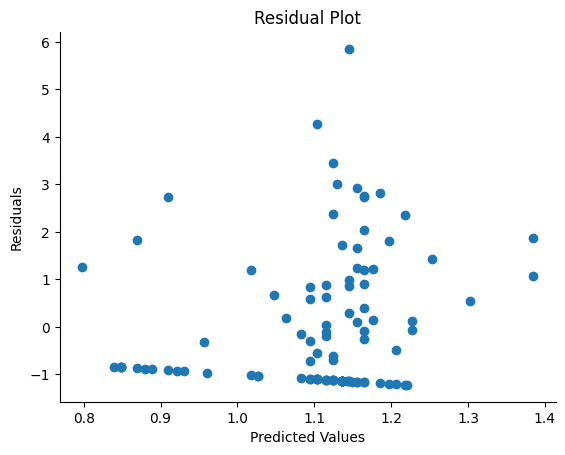

In [762]:
# Plot residuals
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

sns.despine()
plt.show()

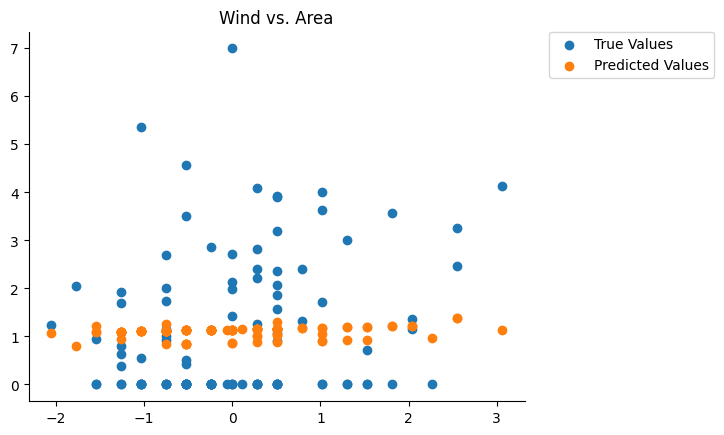

In [771]:
plt.scatter(X_test['wind'], y_test, label='True Values')
plt.scatter(X_test['wind'], y_pred, label='Predicted Values')

plt.title('Wind vs. Area')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

sns.despine()
plt.show()

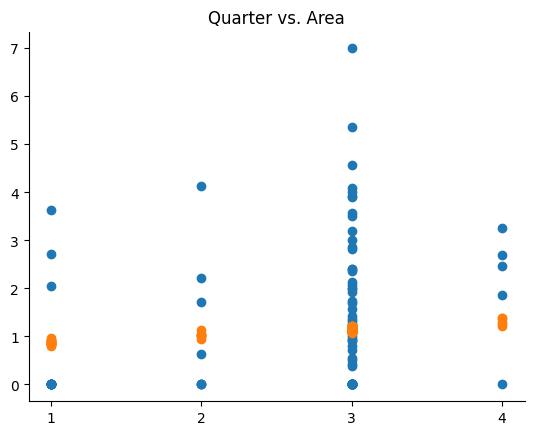

In [775]:
plt.scatter(X_test['quarter'], y_test, label='True Values')
plt.scatter(X_test['quarter'], y_pred, label='Predicted Values')

plt.title('Quarter vs. Area')

plt.xticks([1, 2, 3, 4])

sns.despine()
plt.show()